In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
%load_ext rpy2.ipython

### get rpy2 autocompletion 
from rpy2.robjects import r
from IPython import get_ipython

def rpy2_completer(ipython, event):
    query = event.line.strip().split()[-1]
    suggestions = []
    all_r_symbols = r('sapply(search(), ls)')
    for environment, symbols in all_r_symbols.items():
        for _, symbol in symbols.items():
            if symbol.startswith(query):
                suggestions.append(symbol)
    return suggestions

get_ipython().set_hook('complete_command', rpy2_completer, re_key='.*')

# Processing data before loading to Seurat (skip after first time)

In [8]:
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [9]:
scipy.io.mmwrite('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw.mtx', adata.X)

In [10]:
## get meta data
meta_adata = sc.get.obs_df(adata, keys = adata.obs.columns.tolist())
meta_adata.to_csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_meta.csv')

In [11]:
genes = sc.get.var_df(adata)
genes.to_csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_genes.csv', header=False)

# Loading into Seurat

In [2]:
%%R
library(Seurat)
library(Matrix)
library(ggplot2)
library(ggpubr)



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



In [3]:
%%R
file_path = '/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw.mtx'
raw = readMM(file_path)
raw = t(raw)


In [4]:
%%R
meta = read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_meta.csv', row.names = 1)
head(meta, 5)

                         sample          barcode           guide      lor
miR_1:AAACCCAAGGAGAGGC-1  miR_1 AAACCCAAGGAGAGGC hsa-miR-203a-3p 5.453121
miR_1:AAACCCAAGGTAAACT-1  miR_1 AAACCCAAGGTAAACT   hsa-miR-93-3p 6.012001
miR_1:AAACCCACAACGATCT-1  miR_1 AAACCCACAACGATCT hsa-miR-130b-3p 5.864701
miR_1:AAACCCACACGATTCA-1  miR_1 AAACCCACACGATTCA       TuD_NC_18 5.859895
miR_1:AAACCCACAGTCAACT-1  miR_1 AAACCCACAGTCAACT hsa-miR-147b-5p 5.632808
                                pvalue    adj_pvalue max_umi n_umi     m_umi
miR_1:AAACCCAAGGAGAGGC-1 2.983000e-159 3.010603e-152      67    78 0.1964736
miR_1:AAACCCAAGGTAAACT-1 3.907611e-225 3.943769e-218      97   108 0.2720403
miR_1:AAACCCACAACGATCT-1 3.299362e-202 3.329893e-195      89   113 0.2846348
miR_1:AAACCCACACGATTCA-1 2.574602e-201 2.598426e-194      96   114 0.2871537
miR_1:AAACCCACAGTCAACT-1 3.564463e-178 3.597446e-171      71    86 0.2166247
                            v_umi log_max_umi log_n_umi  log_m_umi
miR_1:AAACCCAAGGAGAGGC-1 11

In [5]:
%%R
gene_names = read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_genes.csv', header = FALSE)
gene_names = gene_names$V1

In [6]:
%%R
colnames(raw) <- rownames(meta)
rownames(raw) <- gene_names

In [7]:
%%R
miR_seurat <- CreateSeuratObject(raw, meta.data = meta)

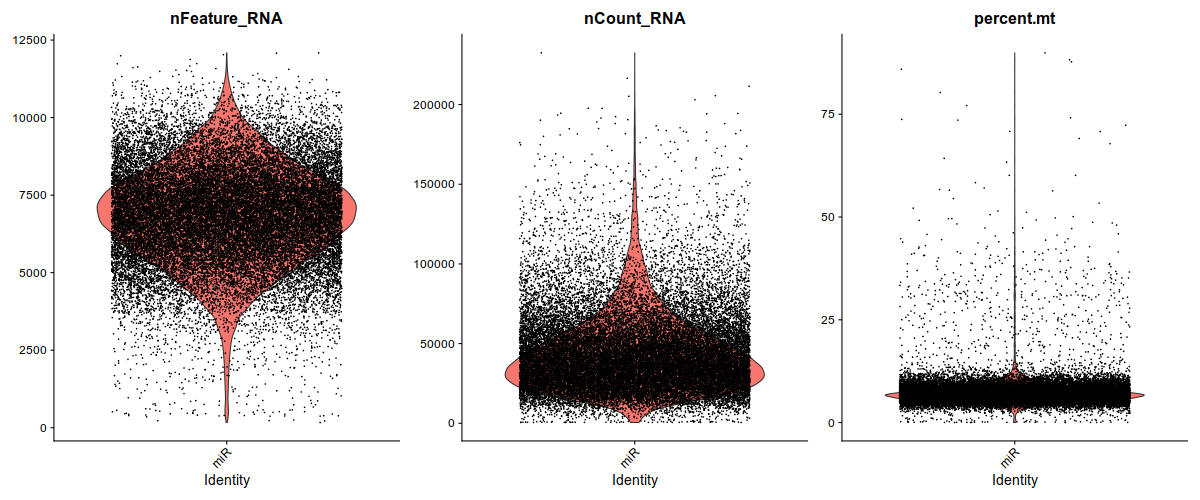

In [8]:
%%R -w 1200 -h 500
miR_seurat[["percent.mt"]] <- PercentageFeatureSet(miR_seurat, pattern = "^MT-")
VlnPlot(miR_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


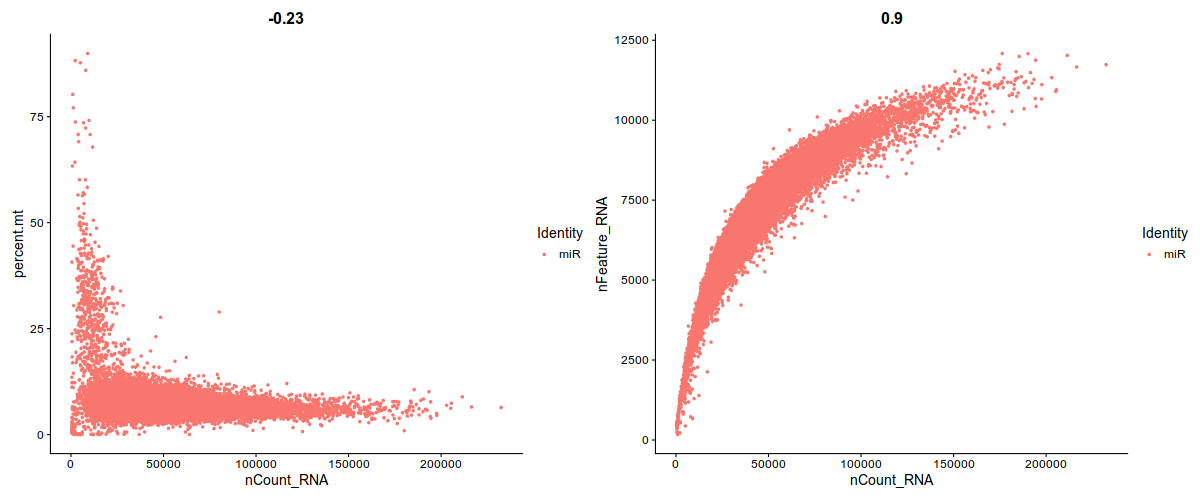

In [9]:
%%R -w 1200 -h 500
plot1 <- FeatureScatter(miR_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(miR_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
options(repr.plot.width=10, repr.plot.height=10)
plot1 + plot2

In [10]:
%%R
miR_seurat <- SCTransform(miR_seurat, vars.to.regress = c("percent.mt", "nCount_RNA"), verbose = TRUE)
miR_seurat <- RunPCA(object = miR_seurat)
miR_seurat <- FindNeighbors(object = miR_seurat)
miR_seurat <- FindClusters(object = miR_seurat)



R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 29179 by 30035

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 76 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 29179 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 29179 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 8.230157 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out percent.mt, nCount_RNA

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                         

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30035
Number of edges: 868047

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.8162
Number of communities: 12
Elapsed time: 5 seconds


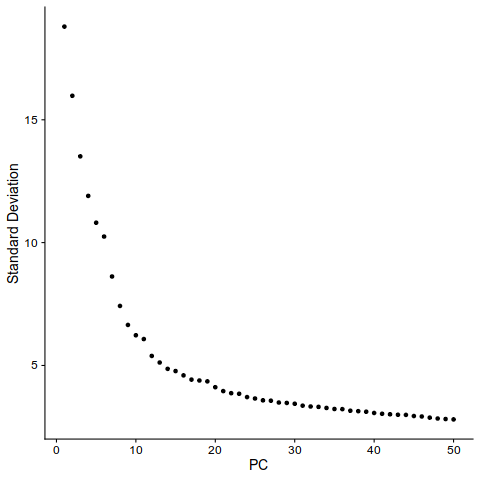

In [11]:
%%R
ElbowPlot(miR_seurat, ndims = 50, reduction = 'pca')

In [12]:
%%R
miR_seurat <- RunUMAP(object = miR_seurat, dims = 1:30)

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: 23:16:26 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: 23:16:26 Read 30035 rows and found 30 numeric columns

R[write to console]: 23:16:26 Using Annoy for neighbor search, n_neighbors = 30

R[write to console]: 23:16:26 Building Annoy index with metric = cosine, n_trees = 50

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *


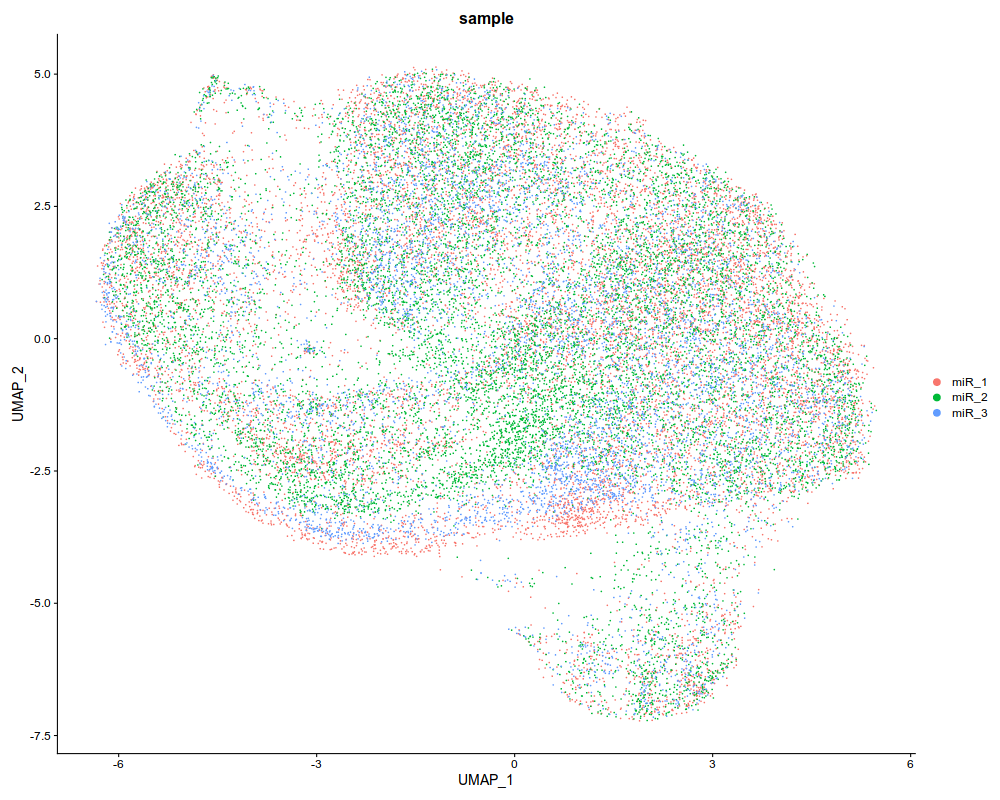

In [13]:
%%R -w 1000 -h 800
DimPlot(object = miR_seurat, reduction = "umap", group.by = "sample")

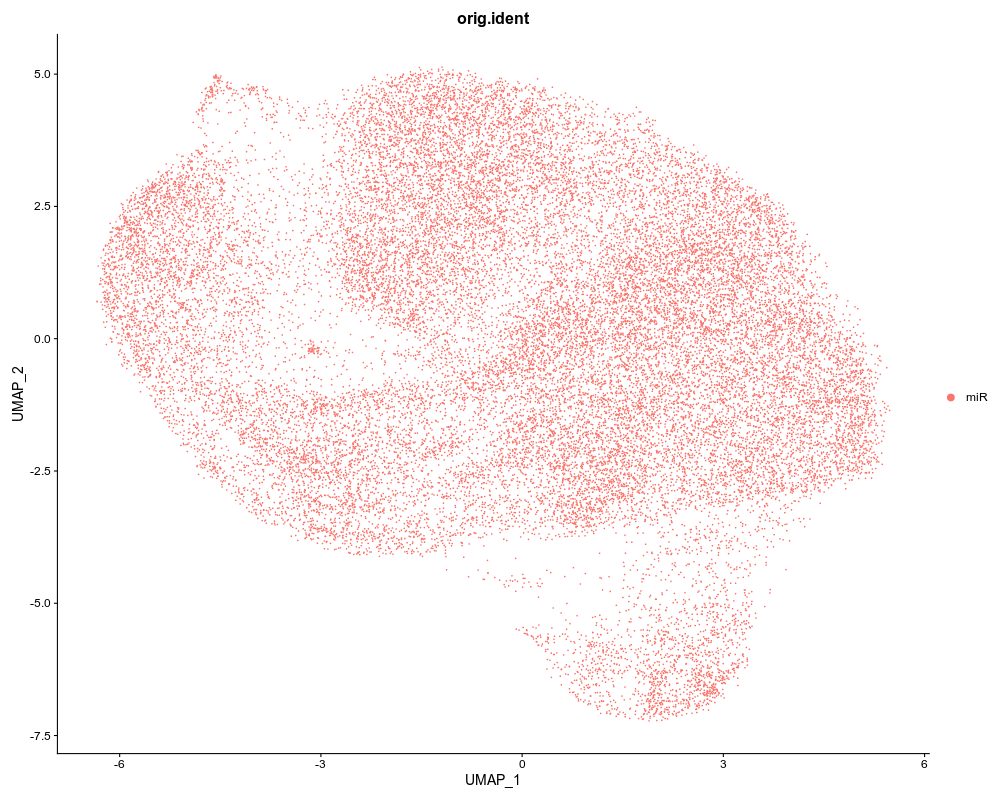

In [6]:
%%R -w 1000 -h 800
DimPlot(object = miR_seurat, reduction = "umap", group.by = "orig.ident")

In [3]:
%%R
## load Seurat object
miR_seurat = readRDS('/home/ssobti/projects/mir_tud/output_data/seurat/miR_seuratobj.RData')

In [ ]:
%%R
## save Seurat object
saveRDS(miR_seurat, '/home/ssobti/projects/mir_tud/output_data/seurat/miR_seuratobj.RData')

In [18]:
%%R -w 1000 -h 1000
umaps <- rep(list('empty'), length(unique(meta$guide)))
perturbs <- unique(meta$guide)
for (i in 1:length(perturbs)){
    nms <- rownames(meta)[meta$guide == perturbs[i]]
    umaps[[i]] <- DimPlot(object = miR_seurat, reduction = "umap", group.by = "guide", cells.highlight = nms, cols.highlight = "red", cols = "grey90") + ggtitle(perturbs[i])
}


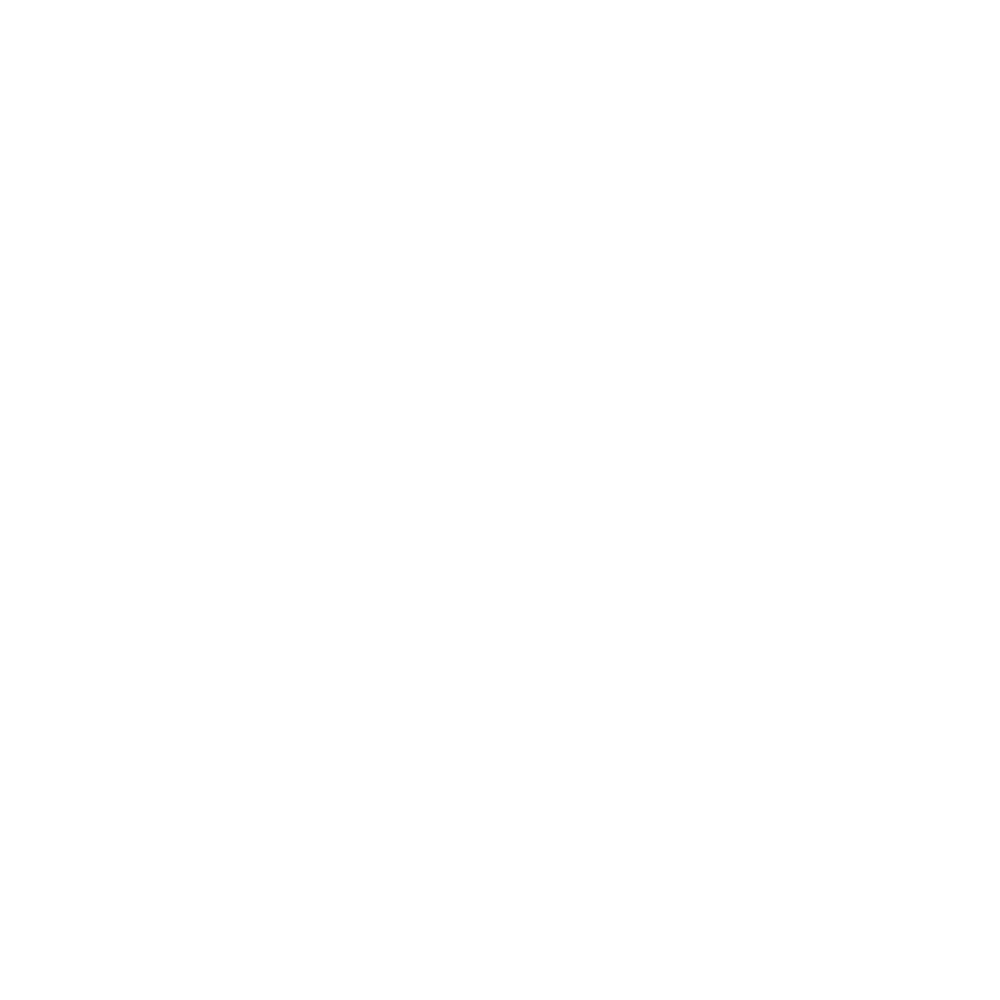

In [19]:
%%R  -w 1000 -h 1000
umap_plts <- rep(list('empty'), ceiling(length(umaps)/25))
for (i in 1:ceiling(length(umaps)/25)){
    umap_plts[[i]] <- ggarrange(plotlist = umaps[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, common.legend = TRUE)
}


In [20]:
%%R
pdf('/home/ssobti/projects/mir_tud/output_data/seurat/miR_perturb_umaps.pdf', height = 12, width = 12)
for (i in 1:length(umap_plts)){
    print(umap_plts[[i]])
}
dev.off()

png 
  2 
